In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./data/train_V2.csv')

# Feature Engineering

In [3]:
df = train[(train['matchType'].isin(['solo','solo-fpp','duo','duo-fpp','squad','squad-fpp']))]

#number of player each match/each team
df['numJoined'] = df.groupby('matchId')['matchId'].transform('count')
df['teamNum'] = df.groupby('groupId')['groupId'].transform('count')

df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
df['headshotPerc'] = df['headshotKills']/df['kills']

#since each game has different num of players, needs to normalize
normalize = (100-df['numJoined'])/100 + 1
df['killsNorm'] = df['kills'] * normalize
df['damageDealtNorm'] = df['damageDealt'] * normalize
df['DBNOsNorm'] = df['DBNOs'] * normalize

df['killstreakOverKills'] = df['killStreaks']/(df['kills'])
df['killsPerDistance'] = df['killsNorm']/(df['totalDistance'] + 1e31)

df['weaponPerDistance'] = df['weaponsAcquired']/(df['totalDistance'] + 1e31)

#assessing teamwork
df['teamContribution'] = preprocessing.scale(df['assists']) + preprocessing.scale(df['revives']) - preprocessing.scale(df['teamKills'])
#solo players do not have teamwork
df['teamContribution'].loc[df['matchType'].isin(['solo','solo-fpp'])] = 0

#explore heals and boost
#allow you to stay out of zone longer
df['healsAndBoosts'] = df['heals'] + df['boosts']
df['healsAndBoostsPerWalkDistance'] = df['healsAndBoosts']/(df['walkDistance']+1e31)
df['healsAndBoostsPerKill'] = df['healsAndBoosts']/(df['killsNorm']+1e31)


#deal with inf and nan
df.replace([np.inf, -np.inf], np.nan)
df.fillna(0,inplace=True)

In [4]:
#features to drop
#cheaters has no control over
feature_drop = ['killPoints','matchDuration','matchType','maxPlace', 'headshotKills',
                'numGroups','rankPoints','winPoints','kills','damageDealt','DBNOs',
                'heals','boosts','numJoined','teamNum','killStreaks','walkDistance',
                'rideDistance','swimDistance']
for feature in feature_drop:
    df.drop(feature, axis=1, inplace=True)

In [5]:
df.to_csv('df_features.csv')

In [282]:
pd.options.display.max_columns = None
df.head()

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,60,0.00,0,0,0,0,1,0.4444,244.8000,0.0,0.00,0.0000,0.0,0.0,0.000000e+00,1.000000e-31,-0.607622,0,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,57,0.00,0,0,0,0,5,0.6400,1445.0445,0.0,0.00,99.7023,0.0,0.0,0.000000e+00,5.000000e-31,-0.607622,0,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,47,0.00,0,0,0,0,2,0.7755,161.8000,0.0,0.00,69.3600,0.0,0.0,0.000000e+00,2.000000e-31,1.145500,0,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,75,0.00,0,0,0,0,3,0.1667,202.7000,0.0,0.00,35.8610,0.0,0.0,0.000000e+00,3.000000e-31,-0.607622,0,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,45,58.53,0,0,0,0,2,0.1875,49.7500,0.0,1.03,103.0000,0.0,1.0,1.030000e-31,2.000000e-31,0.000000,0,0.0,0.0


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4411699 entries, 0 to 4446965
Data columns (total 24 columns):
Id                               object
groupId                          object
matchId                          object
assists                          int64
killPlace                        int64
longestKill                      float64
revives                          int64
roadKills                        int64
teamKills                        int64
vehicleDestroys                  int64
weaponsAcquired                  int64
winPlacePerc                     float64
totalDistance                    float64
headshotPerc                     float64
killsNorm                        float64
damageDealtNorm                  float64
DBNOsNorm                        float64
killstreakOverKills              float64
killsPerDistance                 float64
weaponPerDistance                float64
teamContribution                 float64
healsAndBoosts                   int64
heal

# Feature Importance

In [4]:
def train_test_split(df, test_size=0.3):
    import random
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]

    return train, test

[20]	valid_0's l1: 0.0736216
[40]	valid_0's l1: 0.0713836
[60]	valid_0's l1: 0.0707703
[80]	valid_0's l1: 0.0703278
[100]	valid_0's l1: 0.0700587


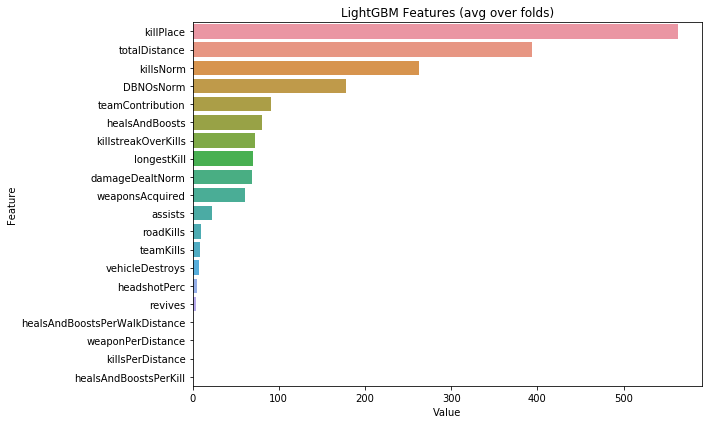

In [284]:
target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.3)

params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'num_leaves': 20,
    'objective': 'regression_l2', 
    'metric': 'mae',
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric='mae',
    verbose=-1,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# Cheaters EDA

## Utility Functions

In [36]:
def outlier_range(var,perc,df):
    return np.percentile(df[var],perc)

def show_countplot(var,title):
    data = df.copy()
    data[var] = data[var].astype('int')
    plt.figure(figsize=(15,10))
    sns.countplot(data[var].sort_values())
    plt.title(title,fontsize=15)
    plt.show()

def show_distplot(var,title):
    plt.figure(figsize=(15,10))
    sns.distplot(df[var],bins=50)
    plt.title(title,fontsize=15)
    plt.show()
    
id_set = set() 

## Kills

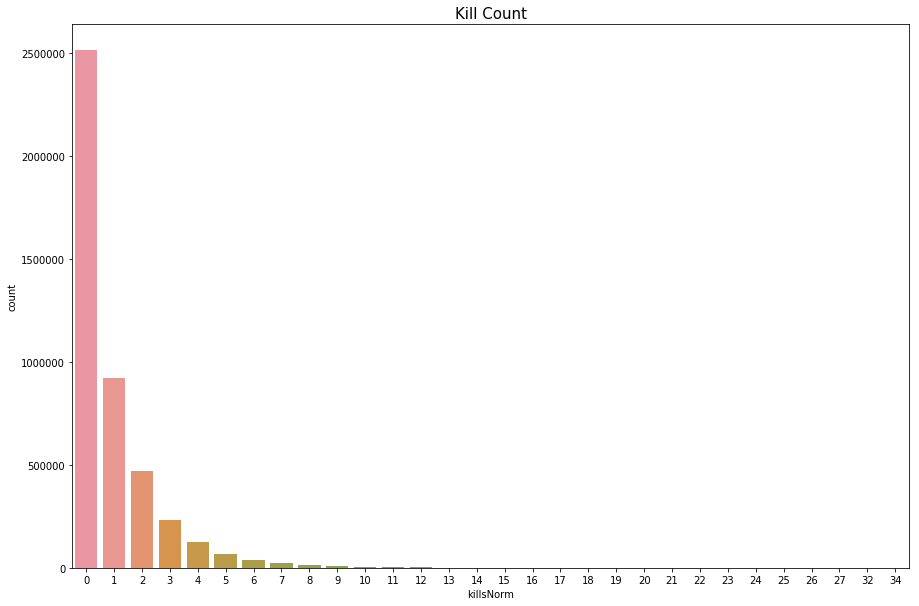

In [286]:
#distribution of kills count
show_countplot('killsNorm','Kill Count')

In [287]:
#players kill the most people
df.sort_values('killsNorm').tail(3)

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
1834930,125775b6f081e8,5293bbd6d0a7d3,4975b53ca28569,0,1,201.40,0,1,0,0,5,1.0,4114.00,0.653846,27.04,2889.12,18.72,0.153846,2.704000e-30,5.000000e-31,-0.607622,6,6.000000e-31,6.000000e-31
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,1,64.29,0,18,0,0,4,1.0,5876.00,0.050000,32.40,3359.88,0.00,0.900000,3.240000e-30,4.000000e-31,0.000000,19,1.900000e-30,1.900000e-30
3840888,7614924933b454,7de402ea23a8ef,59e23ee8543fd2,7,1,227.20,0,0,0,0,6,1.0,9083.48,0.787879,34.98,4023.76,33.92,0.121212,3.498000e-30,6.000000e-31,11.664236,23,2.300000e-30,2.300000e-30


In [288]:
#get the user ids for crazy killers
outlier = np.percentile(df['killsNorm'],99.999)
outlier

21.42

In [289]:
#cheaters id set
id_set.update(df['Id'].loc[df['killsNorm'] >= outlier])

## Road Kills

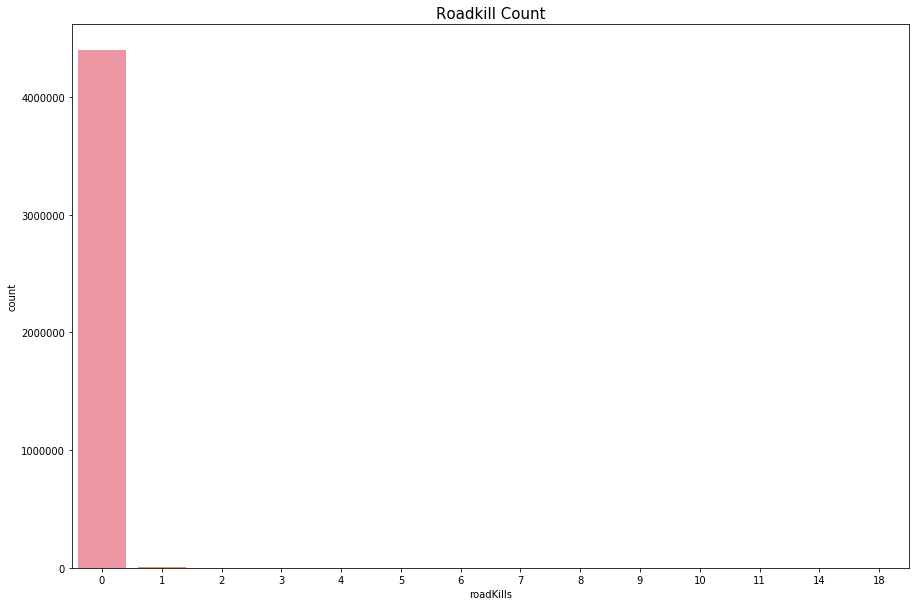

In [328]:
show_countplot('roadKills','Roadkill Count')

In [347]:
df.sort_values('roadKills').tail(5)

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
3954337,4228347e428b79,77ea5e30cffe9a,7c9ba5f5267e54,0,2,0.000,0,10,0,0,0,0.2174,664.080,0.000000,10.70,1070.00,0.0,1.000000,1.070000e-30,0.000000e+00,0.0,0,0.000000e+00,0.000000e+00
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,1,341.400,0,11,0,0,10,0.9398,7853.000,0.277778,20.88,2164.56,0.0,0.611111,2.088000e-30,1.000000e-30,0.0,10,1.000000e-30,1.000000e-30
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,1,0.000,0,11,0,0,5,0.4713,4934.600,0.000000,12.32,1234.24,0.0,1.000000,1.232000e-30,5.000000e-31,0.0,0,0.000000e+00,0.000000e+00
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,1,7.181,0,14,0,0,0,0.4286,1282.302,0.000000,15.12,1345.68,0.0,0.928571,1.512000e-30,0.000000e+00,0.0,0,0.000000e+00,0.000000e+00
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,1,64.290,0,18,0,0,4,1.0000,5876.000,0.050000,32.40,3359.88,0.0,0.900000,3.240000e-30,4.000000e-31,0.0,19,1.900000e-30,1.900000e-30


In [345]:
outlier = int(outlier_range('roadKills',99.9999))
id_set.update(df[df['roadKills']>=outlier]['Id'])

## Weapon Acquired

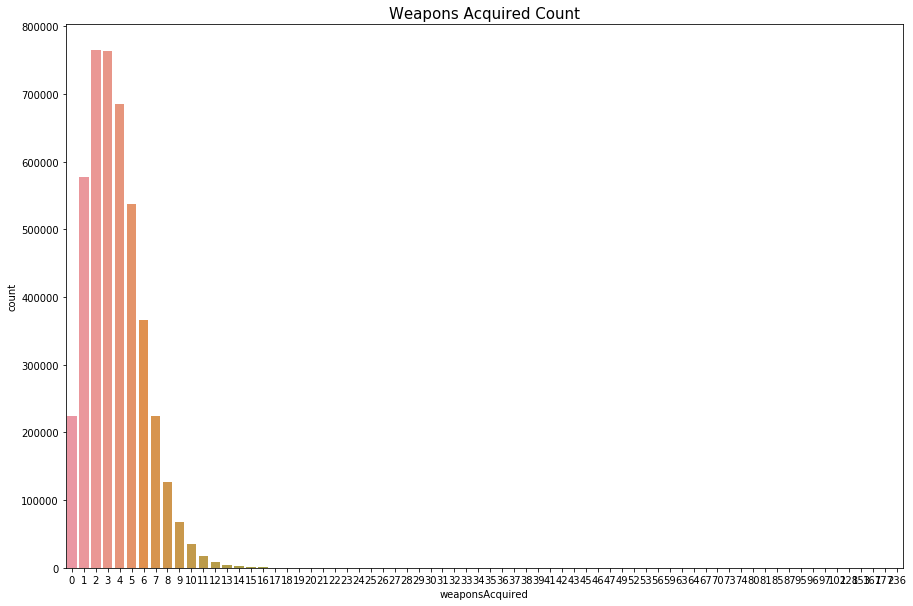

In [290]:
show_countplot('weaponsAcquired','Weapons Acquired Count')

In [291]:
outlier = outlier_range('weaponsAcquired',99.99)
outlier

18.0

In [295]:
#didn't move but get more than 18 weapons?
#probably cheaters
df[(df['weaponsAcquired'] > outlier) & (df['totalDistance'] == 0)]

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
64855,1a3c00d20e5e9a,aa96a6edbcf2df,d99b411f67355d,0,6,0.0,0,0,0,0,22,0.0,0.0,0.0,0.0,396.1800,0.0,0.0,0.0,2.200000e-30,0.0,0,0.000000e+00,0.000000e+00
136460,b5e229ecc2e92f,4eee574e145fd8,e17acf3d7d1205,0,4,0.0,0,0,0,0,20,1.0,0.0,0.0,0.0,242.2420,0.0,0.0,0.0,2.000000e-30,0.0,0,0.000000e+00,0.000000e+00
247557,43a0f3bae7389e,87cf69cb965c4f,76b65f026ac857,0,11,0.0,0,0,0,0,20,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,2.000000e-30,0.0,0,0.000000e+00,0.000000e+00
297479,fb6ad87c67b913,bc1cadcaac712f,7a3021c36e5e1a,0,5,0.0,0,0,0,0,23,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,2.300000e-30,0.0,0,0.000000e+00,0.000000e+00
309584,bf6f55734ed60a,e985176cd8db41,d043dc27463023,0,6,0.0,0,0,0,0,31,0.0,0.0,0.0,0.0,592.9560,0.0,0.0,0.0,3.100000e-30,0.0,0,0.000000e+00,0.000000e+00
328588,b00ba4582648f8,5023fc79c0e9b1,e2e09525c109b3,0,7,0.0,0,0,0,0,21,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,2.100000e-30,0.0,0,0.000000e+00,0.000000e+00
362544,f2b6cad21c6bde,b05ea34696fd38,278f9c9cdc08b1,0,1,0.0,0,0,0,0,23,1.0,0.0,0.0,0.0,397.8420,0.0,0.0,0.0,2.300000e-30,0.0,14,1.400000e-30,1.400000e-30
408261,b47f5e80201d07,cc7cd0dc63342a,d55746dff23ec7,0,4,0.0,0,0,0,0,22,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,2.200000e-30,0.0,0,0.000000e+00,0.000000e+00
423531,2d243fc67960fd,259e60e9f2bbb9,aa48812b7f6eb7,0,4,0.0,0,0,0,0,21,0.0,0.0,0.0,0.0,392.0460,0.0,0.0,0.0,2.100000e-30,0.0,0,0.000000e+00,0.000000e+00
493086,1a5e9e515dac34,45977b5d5db6ee,f0a26d38d1078c,0,10,0.0,0,0,0,0,42,0.0,0.0,0.0,0.0,827.7090,0.0,0.0,0.0,4.200000e-30,0.0,0,0.000000e+00,0.000000e+00


In [301]:
id_set.update(df[(df['weaponsAcquired'] > outlier) & (df['totalDistance'] == 0)]['Id'])

In [236]:
#strange players
df.sort_values('weaponsAcquired').tail(10)

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoostsPerWalkDistance
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,54,0.00,0,0,0,0,95,0.5600,653.10,0.0,0.00,0.0000,0.00,0.000000,0.000000,0.145460,-0.607622,0.000000
2442962,438cabaa5dfbdd,596c155c524725,8e0bbeec19a929,0,56,0.00,0,0,0,0,95,0.5000,807.60,0.0,0.00,0.0000,0.00,0.000000,0.000000,0.117632,-0.607622,0.000000
1834515,e927e9020f7e0d,60d6b714a7308f,8e265af296007b,1,51,0.00,1,0,0,0,96,0.9200,2835.00,0.0,0.00,27.7830,0.00,0.000000,0.000000,0.033862,3.269367,0.000705
4022031,bc2b0e0fc30da4,b5fd53075672cf,281a05959b96e6,1,28,36.79,0,0,0,0,97,0.9787,2464.30,0.0,1.04,250.3280,1.04,1.000000,0.000422,0.039362,1.145500,0.001718
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,24,110.60,0,0,0,0,102,0.8929,5299.21,0.0,1.03,103.0000,0.00,1.000000,0.000194,0.019248,1.145500,0.000000
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,44,0.00,0,0,0,0,128,0.7111,3187.00,0.0,0.00,73.1499,0.00,0.000000,0.000000,0.040163,-0.607622,0.000000
2797867,da68d2812229a8,536975608768ed,fbbdc018f4b771,0,58,0.00,0,0,0,0,153,0.5464,1235.00,0.0,0.00,0.0000,0.00,0.000000,0.000000,0.123887,0.000000,0.000000
2743408,afcb46681b909f,3715298b7eea9c,4dd4d42772464f,0,18,33.43,0,0,1,0,167,0.7955,3318.00,0.0,2.20,205.5900,2.20,1.000000,0.000663,0.050332,-6.628916,0.003652
2749693,940b52bf12805a,4757d102ca4fbf,7ecae2cedc064f,1,7,140.50,0,0,0,0,177,0.8846,3641.70,0.0,3.06,386.4780,2.04,0.333333,0.000840,0.048604,1.145500,0.002397
2982525,3f2bcf53b108c4,2dbc013e849f5a,1df2560f0937ab,0,55,0.00,0,0,0,0,236,0.6786,6890.00,0.0,0.00,86.7085,0.00,0.000000,0.000000,0.034253,-0.607622,0.001420


## Headshot

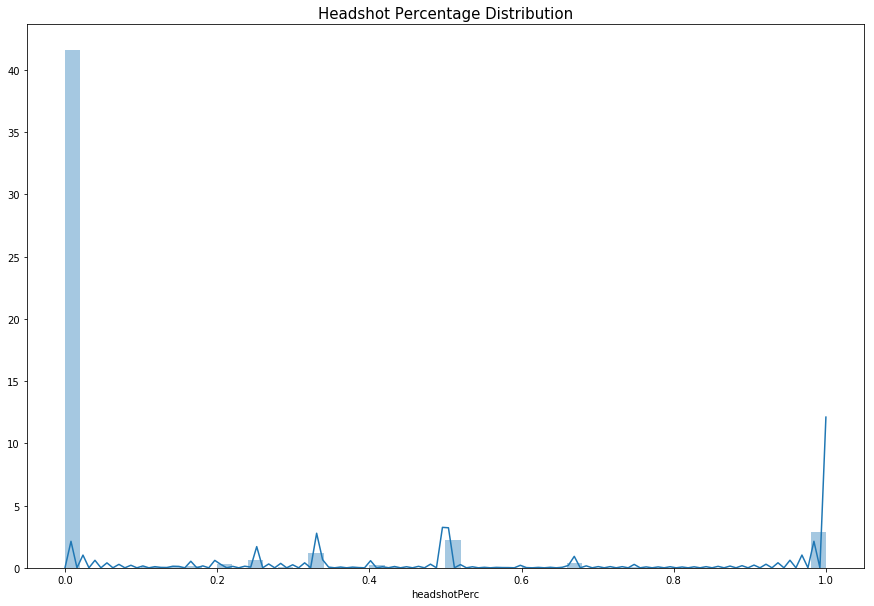

In [304]:
show_distplot('headshotPerc','Headshot Percentage Distribution')

In [305]:
#100% headshot rate shows you are a good player
#but 100% headshot rate when killing a lot, ummmmm...
df[df['headshotPerc']==1].sort_values('killsNorm').tail(10)

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,1,484.90,0,0,0,0,4,1.0000,8178.0,1.0,11.55,1278.90,8.40,0.272727,1.155000e-30,4.000000e-31,-0.607622,8,8.000000e-31,8.000000e-31
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,1,289.60,1,0,0,0,7,1.0000,3108.0,1.0,12.32,1288.00,4.48,0.272727,1.232000e-30,7.000000e-31,3.269367,5,5.000000e-31,5.000000e-31
4428741,6892bbc8af99e3,1fdc1da60d6247,69f854bbfdf3a2,0,1,184.00,0,0,0,0,5,0.9375,1874.0,1.0,12.48,1227.20,7.28,0.166667,1.248000e-30,5.000000e-31,-0.607622,4,4.000000e-31,4.000000e-31
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,1,443.00,0,0,0,0,5,1.0000,5963.0,1.0,12.84,1411.33,11.77,0.166667,1.284000e-30,5.000000e-31,1.145500,6,6.000000e-31,6.000000e-31
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,1,353.80,0,0,0,0,5,1.0000,2105.0,1.0,13.26,1392.30,9.18,0.153846,1.326000e-30,5.000000e-31,-0.607622,4,4.000000e-31,4.000000e-31
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,1,95.14,0,0,0,0,4,1.0000,2479.8,1.0,13.52,1537.12,8.32,0.230769,1.352000e-30,4.000000e-31,-0.607622,12,1.200000e-30,1.200000e-30
2375749,48bd6fdf8719a4,d8a6b7a95481d8,360caa30aabd16,0,1,283.80,0,0,0,0,7,0.9897,2993.4,1.0,14.28,1315.80,0.00,0.142857,1.428000e-30,7.000000e-31,0.000000,9,9.000000e-31,9.000000e-31
2256755,d8474df8d8283a,50c8a5b906d89d,c6da477a07f4aa,0,1,453.80,0,0,0,0,3,1.0000,4994.0,1.0,14.70,1647.45,0.00,0.142857,1.470000e-30,3.000000e-31,0.000000,7,7.000000e-31,7.000000e-31
1753322,74e268b6d4870b,53bfcb6d8229f6,36579d5c2e52bc,0,1,381.20,0,0,0,0,7,1.0000,5008.0,1.0,15.30,1533.06,0.00,0.133333,1.530000e-30,7.000000e-31,0.000000,9,9.000000e-31,9.000000e-31
2825200,246258e735a7e3,9d2590a8ed4809,e9c7b2b19c205a,0,1,243.00,1,0,0,0,6,1.0000,3274.0,1.0,15.60,1675.44,5.20,0.133333,1.560000e-30,6.000000e-31,1.516244,7,7.000000e-31,7.000000e-31


In [307]:
outlier_range('killsNorm',99.9)

11.770000000000001

In [315]:
id_set.update(df[(df['headshotPerc']==1)&(df['killsNorm']>outlier_range('killsNorm',99.9))]['Id'])

## Heals and Boosts

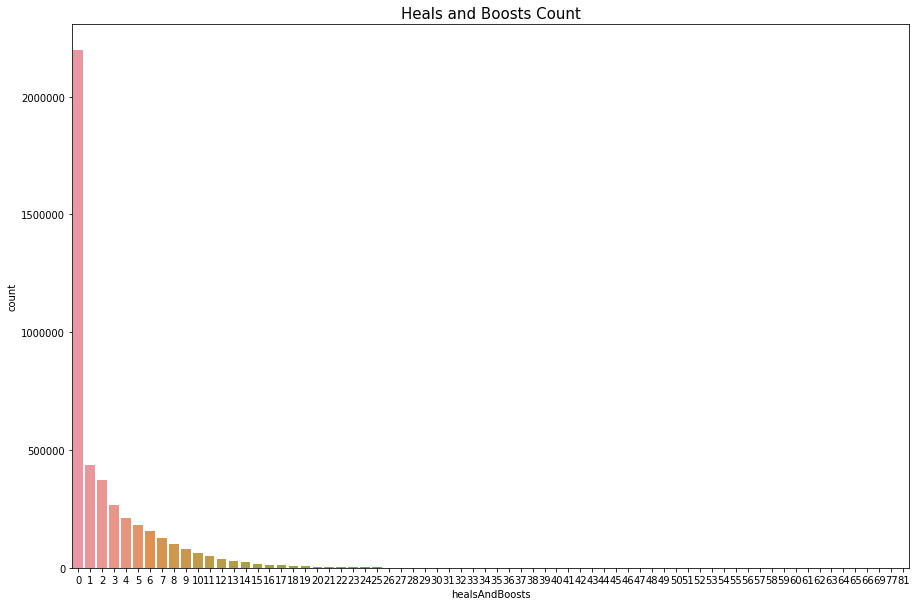

In [251]:
show_countplot('healsAndBoosts','Heals and Boosts Count')

In [317]:
#not using heas and boosts is normal
#but killing 10 people without healing? Ummmm...
df[df['healsAndBoosts']==0].sort_values('killsNorm').tail(10)

,Id,groupId,matchId,assists,killPlace,longestKill,revives,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPlacePerc,totalDistance,headshotPerc,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,1,7.181,0,14,0,0,0,0.4286,1282.302,0.000000,15.12,1345.68,0.00,0.928571,1.512000e-30,0.000000e+00,0.000000,0,0.0,0.0
3094495,38cfb62fe16a1d,03ee04561663ab,6bcf06d055b713,0,1,33.200,0,0,0,0,2,0.6667,968.900,0.933333,16.35,1565.24,0.00,0.866667,1.635000e-30,2.000000e-31,0.000000,0,0.0,0.0
669149,bac98bbc0532fa,39dc8efdad2529,6f8a90ef233ba0,0,1,325.200,0,0,0,0,5,1.0000,3329.200,0.937500,16.64,2360.80,19.76,0.250000,1.664000e-30,5.000000e-31,-0.607622,0,0.0,0.0
652889,aa1293f8a86f83,ee9695eab863af,1173b8f8a45ede,0,1,210.600,0,0,0,0,5,1.0000,3110.000,0.687500,16.64,1712.88,0.00,0.125000,1.664000e-30,5.000000e-31,0.000000,0,0.0,0.0
1204938,cc287ba3f699ec,7fe95bca1feac4,1cef206cc7d12d,1,1,475.900,0,0,0,0,4,0.9200,6002.700,0.733333,16.65,2480.85,19.98,0.200000,1.665000e-30,4.000000e-31,1.145500,0,0.0,0.0
999741,d5ce77c9e4db3b,34eb939dcb5076,9b10dae58bdf6e,0,1,37.240,0,0,1,0,2,0.6477,1074.000,0.600000,16.65,1832.61,0.00,0.800000,1.665000e-30,2.000000e-31,0.000000,0,0.0,0.0
2714364,df578079868527,c9dab2739e98a5,367dd0033fae50,0,1,7.395,0,0,0,0,2,0.4624,258.000,0.312500,16.96,1783.98,0.00,1.000000,1.696000e-30,2.000000e-31,0.000000,0,0.0,0.0
3517965,52334debee0e7d,29ba11de594f79,9688846615612b,1,1,470.500,0,0,0,0,4,1.0000,3058.000,0.117647,17.17,1965.46,7.07,0.176471,1.717000e-30,4.000000e-31,1.145500,0,0.0,0.0
124986,5641fc70c382fa,fb4d09d3c53a24,2258f78c7ef3d9,0,1,0.000,0,0,0,0,8,0.5342,901.700,0.285714,17.64,1764.00,0.00,1.000000,1.764000e-30,8.000000e-31,0.000000,0,0.0,0.0
2033134,1dbd9cec15aa7d,4f038fcbc6d3da,33b5324de9a138,1,1,463.200,0,0,0,0,5,1.0000,2673.000,0.176471,20.23,2175.32,9.52,0.352941,2.023000e-30,5.000000e-31,1.145500,0,0.0,0.0


In [325]:
id_set.update(df[(df['healsAndBoosts']==0)&(df['killsNorm'] > outlier_range('killsNorm',99.99))]['Id'])

# Models

## One class SVM

In [99]:
data_sub,try_ = train_test_split(df,0.977)

In [100]:
len(data_sub)

101394

In [14]:
target_num = 100000
1 - target_num/len(df)

0.9773329957460833

In [101]:

outliers_fraction = 0.1
data = data_sub[['roadKills','killsNorm','weaponPerDistance','healsAndBoostsPerKill','headshotPerc']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction,verbose=False) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
data_sub['anomaly'] = model.predict(data)
data_sub['anomaly'] = data_sub['anomaly'].map( {1: 0, -1: 1} )
print(data_sub['anomaly'].value_counts())

0    87394
1    14000
Name: anomaly, dtype: int64


In [102]:
data_sub.groupby('anomaly').mean()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,killsNorm,damageDealtNorm,DBNOsNorm,killstreakOverKills,killsPerDistance,weaponPerDistance,teamContribution,healsAndBoosts,healsAndBoostsPerWalkDistance,healsAndBoostsPerKill
anomaly,,,,,,,,,,,,,,,,,,,,,
0,0.210026,0.981440,115.806838,0.573163,0.164531,1.070588,48.214385,521.573586,0.764057,0.506408,...,0.804923,122.183645,0.604246,0.331919,8.049231e-32,3.597913e-31,0.039541,2.052029,2.052029e-31,2.052029e-31
1,0.330571,1.864143,214.594663,1.139643,0.611500,3.062929,44.375643,507.738000,1.846571,0.760286,...,1.955172,227.431855,1.207504,0.299949,1.955172e-31,3.827714e-31,0.408828,4.927071,4.927071e-31,4.927071e-31


In [ ]:
#kills
id_set = set()
outlier = np.percentile(data_sub['killsNorm'],99)
id_set.update(data_sub['Id'].loc[data_sub['killsNorm'] >= outlier])

#roadkills
outlier = int(outlier_range('roadKills',99.9,data_sub))
id_set.update(data_sub[data_sub['roadKills']>=outlier]['Id'])

#weapon
outlier = outlier_range('weaponsAcquired',99,data_sub)
id_set.update(data_sub[(data_sub['weaponsAcquired'] > outlier) & (data_sub['totalDistance'] == 0)]['Id'])

id_set.update(data_sub[(data_sub['headshotPerc']==1)&(data_sub['killsNorm']>outlier_range('killsNorm',99,data_sub))]['Id'])

id_set.update(data_sub[(data_sub['healsAndBoosts']==0)&(data_sub['killsNorm'] > outlier_range('killsNorm',99,data_sub))]['Id'])

In [108]:
len(id_set)

1328

In [109]:
cheater_id = data_sub['Id'].loc[data_sub['anomaly']==1]

In [110]:
len(set(cheater_id) & id_set)

1312

In [112]:
len(set(cheater_id) & id_set) / len(id_set) * 100

98.79518072289156

## Isolation Forest

In [114]:
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
data_sub['anomaly_if'] = model.predict(data)
data_sub['anomaly_if'] = data_sub['anomaly_if'].map( {1: 0, -1: 1} )
print(data_sub['anomaly_if'].value_counts())

0    91254
1    10140
Name: anomaly2, dtype: int64


In [115]:
cheater_id2 = data_sub['Id'].loc[data_sub['anomaly2']==1]

In [117]:
len(set(cheater_id2) & id_set)/len(id_set) * 100

92.16867469879519

## Clustering

In [121]:
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data2 = pd.DataFrame(np_scaled)

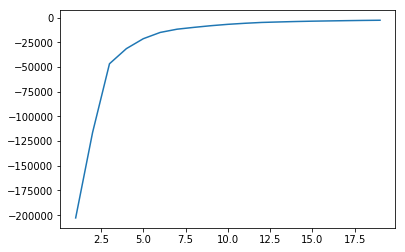

In [122]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data2) for i in n_cluster]
scores = [kmeans[i].score(data2) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [143]:
data_sub['cluster'] = kmeans[1].predict(data2)
data_sub['principal_feature1'] = data2[0]
data_sub['principal_feature2'] = data2[1]

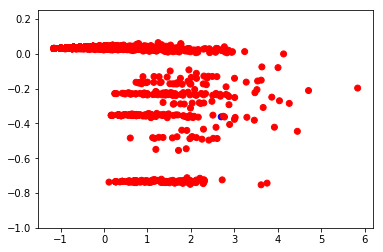

In [146]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange'}
ax.scatter(data_sub['principal_feature1'], data_sub['principal_feature2'], 
           c=data_sub["cluster"].apply(lambda x: colors[x]))
plt.ylim(-1,0.25)
plt.show()

In [138]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance
distance = getDistanceByPoint(data2, kmeans[4])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
data_sub['anomaly3'] = (distance >= threshold).astype(int)

In [139]:
print(data_sub['anomaly3'].value_counts())

0.0    1886
1.0     329
Name: anomaly3, dtype: int64


In [140]:
data_sub['anomaly3']

7          0.0
10         1.0
26         0.0
105        0.0
110        0.0
117        0.0
127        0.0
142        0.0
204        0.0
212        0.0
222        0.0
393        0.0
512        0.0
587        0.0
616        0.0
688        0.0
762        0.0
787        0.0
806        0.0
811        0.0
820        0.0
881        1.0
927        0.0
953        0.0
1059       0.0
1069       0.0
1077       0.0
1089       0.0
1124       0.0
1173       0.0
          ... 
4445736    NaN
4445756    NaN
4445854    NaN
4445889    NaN
4445895    NaN
4445934    NaN
4445964    NaN
4445982    NaN
4445987    NaN
4445999    NaN
4446148    NaN
4446179    NaN
4446214    NaN
4446235    NaN
4446263    NaN
4446268    NaN
4446330    NaN
4446536    NaN
4446574    NaN
4446596    NaN
4446629    NaN
4446654    NaN
4446660    NaN
4446756    NaN
4446800    NaN
4446845    NaN
4446852    NaN
4446892    NaN
4446920    NaN
4446925    NaN
Name: anomaly3, Length: 101394, dtype: float64